1. CÀI ĐẶT THƯ VIỆN CẦN THIẾT

In [18]:
import sys
sys.modules["cupy"] = None


In [19]:
!pip install pyvi


In [20]:
import spacy
nlp = spacy.blank("vi")


In [21]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [22]:
pip install openai

Note: you may need to restart the kernel to use updated packages.


In [23]:
import json
import spacy
import os

import numpy                            as np
import pandas                           as pd
import matplotlib.pyplot                as plt

from sklearn.feature_extraction.text    import CountVectorizer
from sklearn.decomposition              import LatentDirichletAllocation
from sklearn.metrics.pairwise           import cosine_distances
from collections                        import defaultdict
from sklearn.feature_extraction.text    import TfidfVectorizer
from sklearn.decomposition              import TruncatedSVD, NMF
from sklearn.metrics                    import silhouette_score
from gensim.corpora                     import Dictionary
from gensim.models.coherencemodel       import CoherenceModel
from spacy.lang.vi                      import Vietnamese
from openai                             import OpenAI

In [ ]:
pip install keybert easynmt

In [24]:
with open("/kaggle/input/dataset-final/data.json", "r", encoding="utf-8") as f:
    df = json.load(f)

df = pd.DataFrame(df)

texts = df["text_tfidf"].astype(str).tolist()

tokens = [t.split() for t in texts]
dictionary = Dictionary(tokens)

1. LDA

In [27]:
counts_vectorizer = CountVectorizer(
    max_df=0.9,
    min_df=5,
    token_pattern=r"(?u)\b\w+\b"
)

X_counts = counts_vectorizer.fit_transform(texts)
feature_names = counts_vectorizer.get_feature_names_out()

print("BoW shape:", X_counts.shape)

BoW shape: (11226, 18754)


In [29]:
def get_model_top_words(model, feature_names, topn=10):
    return [
        [feature_names[i] for i in topic.argsort()[-topn:][::-1]]
        for topic in model.components_
    ]

In [30]:
def compute_compactness(doc_topic_dist):
    labels = doc_topic_dist.argmax(axis=1)
    compactness_values = []

    for topic in np.unique(labels):
        idx = np.where(labels == topic)[0]
        if len(idx) <= 1:
            continue

        vectors = doc_topic_dist[idx]
        centroid = vectors.mean(axis=0, keepdims=True)
        distances = cosine_distances(vectors, centroid)
        compactness_values.append(distances.mean())

    return np.mean(compactness_values)


def compute_separation(doc_topic_dist):
    labels = doc_topic_dist.argmax(axis=1)
    centroids = []

    for topic in np.unique(labels):
        idx = np.where(labels == topic)[0]
        if len(idx) == 0:
            continue

        centroids.append(doc_topic_dist[idx].mean(axis=0))

    centroids = np.array(centroids)

    if len(centroids) <= 1:
        return 0.0

    dist_matrix = cosine_distances(centroids)
    upper_triangle = dist_matrix[np.triu_indices_from(dist_matrix, k=1)]

    return upper_triangle.mean()

In [31]:
k_list = range(5, 13)
feature_names = counts_vectorizer.get_feature_names_out()
results = []

for k in k_list:
    lda = LatentDirichletAllocation(
        n_components=k,
        random_state=42,
        learning_method="batch",
        max_iter=20,
        n_jobs=1
    )
    lda.fit(X_counts)

    doc_topic_dist = lda.transform(X_counts)

    comp = compute_compactness(doc_topic_dist)
    sep  = compute_separation(doc_topic_dist)
    score = sep / comp

    topics_words = get_model_top_words(lda, feature_names, topn=10)
    coh = CoherenceModel(
        topics=topics_words,
        texts=tokens,
        dictionary=dictionary,
        coherence="c_v"
    ).get_coherence()

    results.append({
        "K": k,
        "compactness": comp,
        "separation": sep,
        "score": score,
        "coherence": coh
    })

    print(f"K={k:02d} | Comp={comp:.4f} | Sep={sep:.4f} | Score={score:.4f} | Coh={coh:.4f}")

res_df = pd.DataFrame(results)
res_df

K=05 | Comp=0.0479 | Sep=0.8562 | Score=17.8724 | Coh=0.6162
K=06 | Comp=0.0510 | Sep=0.8737 | Score=17.1293 | Coh=0.6838
K=07 | Comp=0.0580 | Sep=0.8725 | Score=15.0521 | Coh=0.7054
K=08 | Comp=0.0644 | Sep=0.8714 | Score=13.5258 | Coh=0.7008
K=09 | Comp=0.0680 | Sep=0.8820 | Score=12.9785 | Coh=0.6811
K=10 | Comp=0.0694 | Sep=0.8883 | Score=12.7921 | Coh=0.6865
K=11 | Comp=0.0786 | Sep=0.8836 | Score=11.2385 | Coh=0.6857
K=12 | Comp=0.0839 | Sep=0.8831 | Score=10.5216 | Coh=0.6668


,K,compactness,separation,score,coherence
0,5,0.047906,0.856204,17.872412,0.616186
1,6,0.051007,0.873712,17.129306,0.683780
2,7,0.057966,0.872512,15.052084,0.705398
3,8,0.064426,0.871418,13.525826,0.700760
4,9,0.067958,0.881987,12.978509,0.681128
5,10,0.069444,0.888338,12.792136,0.686541
6,11,0.078626,0.883646,11.238541,0.685749
7,12,0.083929,0.883064,10.521558,0.666827


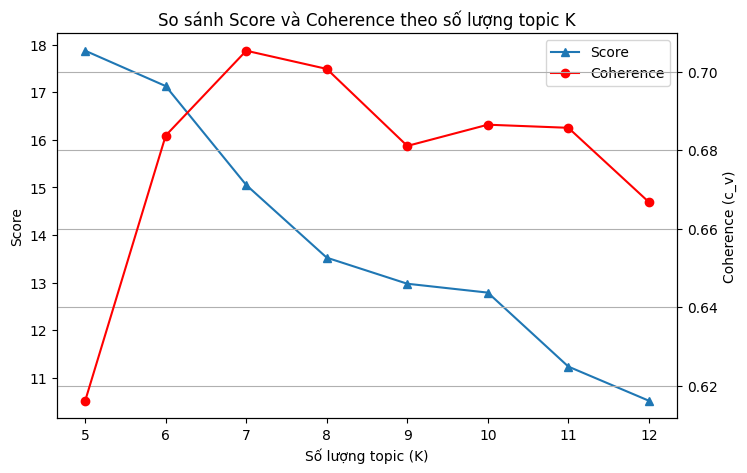

In [32]:
fig, ax1 = plt.subplots(figsize=(8,5))

ax1.plot(res_df["K"], res_df["score"], marker='^', label="Score")
ax1.set_xlabel("Số lượng topic (K)")
ax1.set_ylabel("Score")

ax2 = ax1.twinx()
ax2.plot(res_df["K"], res_df["coherence"], marker='o', label="Coherence", color ='red')
ax2.set_ylabel("Coherence (c_v)")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

plt.title("So sánh Score và Coherence theo số lượng topic K")
plt.grid(True)
plt.show()


In [33]:
lda_final = LatentDirichletAllocation(
    n_components=7,
    random_state=42,
    learning_method="batch",
    max_iter=20,
    n_jobs=1
)
lda_final.fit(X_counts)

LatentDirichletAllocation(max_iter=20, n_components=7, n_jobs=1,
                          random_state=42)

In [34]:
topics_words = get_model_top_words(lda_final, feature_names, topn=20)

for i, words in enumerate(topics_words):
    print(f"Topic {i}: {', '.join(words)}")

doc_topic_dist = lda_final.transform(X_counts)
dominant_topic = doc_topic_dist.argmax(axis=1)

Topic 0: đồng, tỷ, triệu, tiền, công_ty, giá, usd, hàng, công_an, vàng, thị_trường, vụ, mua, kinh_doanh, ngân_hàng, quy_định, tài_sản, thuế, điều_tra, bị_cáo
Topic 1: trận, việt_nam, đội, đấu, hai, bóng, giải, u, giành, thi_đấu, cầu_thủ, thắng, vòng, sân, bảng, nữ, hlv, ảnh, sea_games, chiến_thắng
Topic 2: tỉnh, ủy, chủ_tịch, phó, tổ_chức, ban, công_tác, trung_ương, địa_phương, cán_bộ, chính_trị, nhiệm_vụ, bí_thư, xã, đảng, quy_định, nhân_dân, ubnd, quốc_hội, chỉ_đạo
Topic 3: ảnh, đi, phim, hai, khán_giả, gia_đình, việt_nam, diễn_viên, đẹp, mẹ, sống, diễn, nghệ_sĩ, hình_ảnh, gái, hoa_hậu, trẻ, ca_sĩ, nghệ_thuật, nữ
Topic 4: việt_nam, phát_triển, kinh_tế, xây_dựng, hai, hợp_tác, doanh_nghiệp, quốc_tế, xã_hội, đầu_tư, quốc_gia, công_nghệ, chiến_lược, hiệu_quả, thủ_tướng, đổi_mới, dự_án, mục_tiêu, chính_sách, chính_phủ
Topic 5: bệnh_viện, bệnh, bác_sĩ, y_tế, bệnh_nhân, điều_trị, giúp, thuốc, khỏe, nguy_cơ, đường, sức, ung_thư, trẻ, máu, cơ_thể, sức_khỏe, uống, thực_phẩm, tim
Topic 6: trườ

In [35]:
def caption_compound_then_single(words, k=4):
    # words đã được sắp theo trọng số giảm dần từ LDA
    compounds = [w for w in words if "_" in w]
    singles   = [w for w in words if "_" not in w]

    ordered = compounds + singles
    return " ".join(w.replace("_", " ") for w in ordered[:k])
for i, words in enumerate(topics_words):
    print(f"Topic {i}: {caption_compound_then_single(words)}")

Topic 0: công ty công an thị trường kinh doanh
Topic 1: việt nam thi đấu cầu thủ sea games
Topic 2: chủ tịch tổ chức công tác trung ương
Topic 3: khán giả gia đình việt nam diễn viên
Topic 4: việt nam phát triển kinh tế xây dựng
Topic 5: bệnh viện bác sĩ y tế bệnh nhân
Topic 6: đại học giáo dục học sinh chương trình


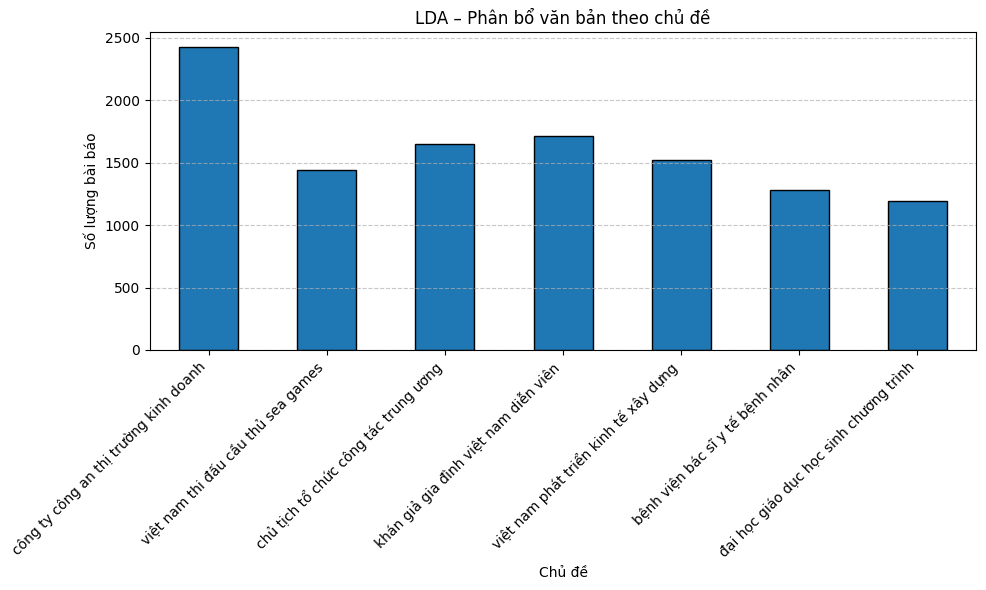

In [36]:
topic_captions = {
    i: caption_compound_then_single(words, k=4)
    for i, words in enumerate(topics_words)
}

topic_captions
doc_topic_dist = lda_final.transform(X_counts)
dominant_topic = doc_topic_dist.argmax(axis=1)

topic_counts = (
    pd.Series(dominant_topic)
    .value_counts()
    .sort_index()
)
plt.figure(figsize=(10, 6))

topic_counts.plot(
    kind="bar",
    edgecolor="black"
)

plt.title(f"LDA – Phân bổ văn bản theo chủ đề")
plt.xlabel("Chủ đề")
plt.ylabel("Số lượng bài báo")

plt.xticks(
    ticks=range(len(topic_counts)),
    labels=[topic_captions[i] for i in topic_counts.index],
    rotation=45,
    ha="right"
)

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

2. NMF

In [169]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9
)

X_tfidf = tfidf_vectorizer.fit_transform(df["text_ws"].astype(str))
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())


In [38]:
k_list = range(5, 13)
results_nmf = []

for k in k_list:
    nmf = NMF(
        n_components=k,
        random_state=42,
        init="nndsvd",
        max_iter=300
    )

    W = nmf.fit_transform(X_tfidf)   # doc–topic

    comp = compute_compactness(W)
    sep  = compute_separation(W)
    score = sep / comp

    topics_words = get_model_top_words(nmf, feature_names, topn=10)

    cm = CoherenceModel(
        topics=topics_words,
        texts=tokens,
        dictionary=dictionary,
        coherence="c_v"
    )
    coh = cm.get_coherence()

    results_nmf.append({
        "K": k,
        "compactness": comp,
        "separation": sep,
        "score": score,
        "coherence": coh
    })

    print(
        f"NMF | K={k:02d} | "
        f"Comp={comp:.4f} | Sep={sep:.4f} | "
        f"Score={score:.4f} | Coh={coh:.4f}"
    )

res_nmf_df = pd.DataFrame(results_nmf)
res_nmf_df

NMF | K=05 | Comp=0.0548 | Sep=0.8214 | Score=14.9995 | Coh=0.7286
NMF | K=06 | Comp=0.0589 | Sep=0.8426 | Score=14.3033 | Coh=0.7838
NMF | K=07 | Comp=0.0610 | Sep=0.8587 | Score=14.0663 | Coh=0.8039
NMF | K=08 | Comp=0.0656 | Sep=0.8644 | Score=13.1871 | Coh=0.7935
NMF | K=09 | Comp=0.0740 | Sep=0.8697 | Score=11.7525 | Coh=0.7964
NMF | K=10 | Comp=0.0759 | Sep=0.8769 | Score=11.5511 | Coh=0.7805
NMF | K=11 | Comp=0.0807 | Sep=0.8764 | Score=10.8620 | Coh=0.7808
NMF | K=12 | Comp=0.0817 | Sep=0.8844 | Score=10.8230 | Coh=0.7929


,K,compactness,separation,score,coherence
0,5,0.054760,0.821374,14.999464,0.728554
1,6,0.058907,0.842556,14.303267,0.783765
2,7,0.061043,0.858651,14.066299,0.803914
3,8,0.065551,0.864427,13.187064,0.793475
4,9,0.074003,0.869716,11.752522,0.796407
5,10,0.075917,0.876920,11.551075,0.780487
6,11,0.080688,0.876434,10.861963,0.780845
7,12,0.081710,0.884352,10.823013,0.792909


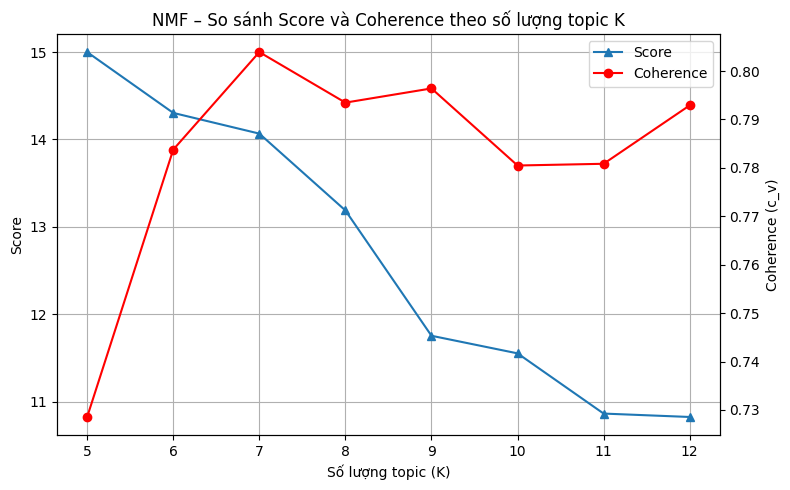

In [39]:
fig, ax1 = plt.subplots(figsize=(8,5))

ax1.plot(res_nmf_df["K"], res_nmf_df["score"], marker='^', label="Score")
ax1.set_xlabel("Số lượng topic (K)")
ax1.set_ylabel("Score")

ax2 = ax1.twinx()
ax2.plot(res_nmf_df["K"], res_nmf_df["coherence"], marker='o',
         label="Coherence", color='red')
ax2.set_ylabel("Coherence (c_v)")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

plt.title("NMF – So sánh Score và Coherence theo số lượng topic K")
ax1.grid(True)
plt.tight_layout()
plt.show()


In [41]:
nmf_final = NMF(
    n_components=7,
    random_state=42,
    init="nndsvd",
    max_iter=300
)

W = nmf_final.fit_transform(X_tfidf)

In [42]:
topics_words_nmf = get_model_top_words(nmf_final, feature_names, topn=20)
for i, words in enumerate(topics_words_nmf):
    print(f"Topic {i}: {', '.join(words)}")

Topic 0: việt_nam, phát_triển, thủ_tướng, hợp_tác, kinh_tế, xây_dựng, tổng_bí_thư, đảng, doanh_nghiệp, nhân_dân, chính_phủ, địa_phương, quốc_hội, công_nghệ, chính_trị, chiến_lược, đổi_mới, tổ_chức, đầu_tư, xã_hội
Topic 1: trận, đội, đấu, việt_nam, bóng, cầu_thủ, trận đấu, hlv, malaysia, thắng, giành, bảng, giải, sea_games, thi_đấu, bàn, vòng, chiến_thắng, sân, đội_tuyển
Topic 2: tỉnh, ủy, bí_thư, tỉnh ủy, phó, chủ_tịch, bí_thư tỉnh, ubnd, ban, chủ_tịch ubnd, phó bí_thư, chức, ubnd tỉnh, nhiệm_kỳ, chính_trị, đảng_bộ, trung_ương, đại_hội, thành ủy, hđnd
Topic 3: đồng, tỷ, tỷ đồng, triệu, công_ty, giá, vàng, triệu đồng, tiền, usd, cổ_phiếu, thị_trường, công_an, thuế, ngân_hàng, bị_cáo, giao_dịch, mua, giá vàng, tài_sản
Topic 4: bác_sĩ, bệnh_viện, bệnh_nhân, bệnh, điều_trị, y_tế, thuốc, ung_thư, máu, tim, thận, nguy_cơ, cấp_cứu, người_bệnh, gan, não, phẫu_thuật, khỏe, uống, ca
Topic 5: trường, đại_học, học_sinh, giáo_dục, sinh_viên, học, thi, đào_tạo, giáo_viên, trường đại_học, ngành, lớp,

In [43]:
topic_captions_nmf = {
    i: caption_compound_then_single(words)
    for i, words in enumerate(topics_words_nmf)
}

for i, cap in topic_captions_nmf.items():
    print(f"Topic {i}: {cap}")

Topic 0: việt nam phát triển thủ tướng hợp tác
Topic 1: việt nam cầu thủ sea games thi đấu
Topic 2: bí thư chủ tịch bí thư tỉnh chủ tịch ubnd
Topic 3: công ty cổ phiếu thị trường công an
Topic 4: bác sĩ bệnh viện bệnh nhân điều trị
Topic 5: đại học học sinh giáo dục sinh viên
Topic 6: diễn viên khán giả ca sĩ nghệ sĩ


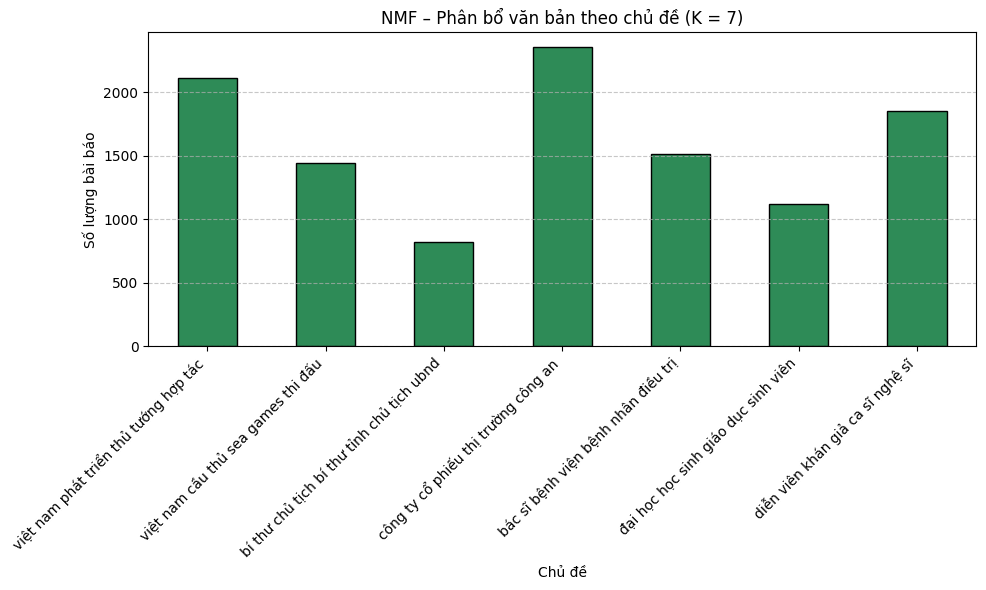

In [44]:
dominant_topic_nmf = W.argmax(axis=1)

topic_counts_nmf = (
    pd.Series(dominant_topic_nmf)
    .value_counts()
    .sort_index()
)
plt.figure(figsize=(10,6))

topic_counts_nmf.plot(
    kind="bar",
    edgecolor="black",
    color="seagreen"
)

plt.title("NMF – Phân bổ văn bản theo chủ đề (K = 7)")
plt.xlabel("Chủ đề")
plt.ylabel("Số lượng bài báo")

plt.xticks(
    ticks=range(len(topic_counts_nmf)),
    labels=[topic_captions_nmf[i] for i in topic_counts_nmf.index],
    rotation=45,
    ha="right"
)

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

3. LSA

In [46]:
lsa_final = TruncatedSVD(
    n_components=7,
    random_state=42
)

X_lsa = lsa_final.fit_transform(X_tfidf)

In [48]:
k_list = range(5, 13)
results_lsa = []

for k in k_list:
    lsa = TruncatedSVD(n_components=k, random_state=42)
    X_lsa = lsa.fit_transform(X_tfidf)   # doc–topic

    comp = compute_compactness(X_lsa)
    sep  = compute_separation(X_lsa)
    score = sep / comp

    topics_words = [
        [feature_names[i] for i in compo.argsort()[-10:][::-1]]
        for compo in lsa.components_
    ]

    coh = CoherenceModel(
        topics=topics_words,
        texts=tokens,
        dictionary=dictionary,
        coherence="c_v"
    ).get_coherence()

    results_lsa.append({
        "K": k,
        "compactness": comp,
        "separation": sep,
        "score": score,
        "coherence": coh
    })

    print(f"LSA | K={k:02d} | Comp={comp:.4f} | Sep={sep:.4f} | Score={score:.4f} | Coh={coh:.4f}")

res_lsa_df = pd.DataFrame(results_lsa)

LSA | K=05 | Comp=0.0743 | Sep=0.7584 | Score=10.2096 | Coh=0.5912
LSA | K=06 | Comp=0.0769 | Sep=0.7768 | Score=10.1045 | Coh=0.6279
LSA | K=07 | Comp=0.0831 | Sep=0.7538 | Score=9.0677 | Coh=0.5726
LSA | K=08 | Comp=0.0895 | Sep=0.7895 | Score=8.8177 | Coh=0.5661
LSA | K=09 | Comp=0.0956 | Sep=0.8225 | Score=8.6073 | Coh=0.5471
LSA | K=10 | Comp=0.1040 | Sep=0.8175 | Score=7.8605 | Coh=0.5218
LSA | K=11 | Comp=0.1219 | Sep=0.8092 | Score=6.6388 | Coh=0.5279
LSA | K=12 | Comp=0.1259 | Sep=0.8121 | Score=6.4526 | Coh=0.5333


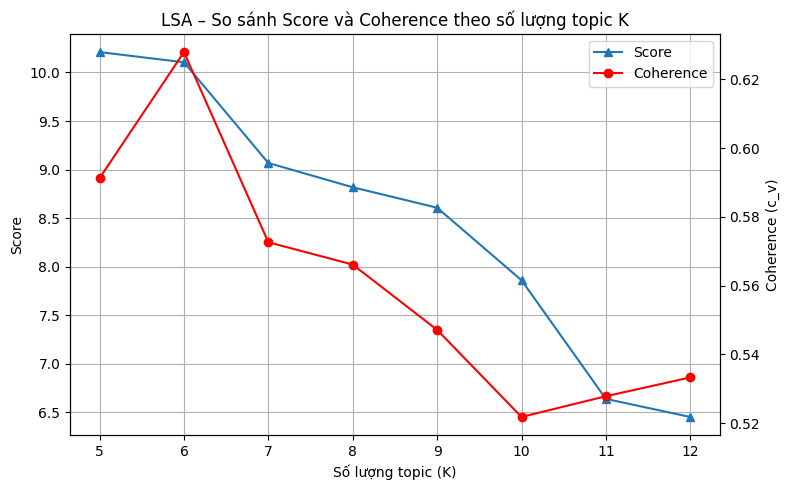

In [49]:
fig, ax1 = plt.subplots(figsize=(8,5))

ax1.plot(res_lsa_df["K"], res_lsa_df["score"], marker='^', label="Score")
ax1.set_xlabel("Số lượng topic (K)")
ax1.set_ylabel("Score")

ax2 = ax1.twinx()
ax2.plot(res_lsa_df["K"], res_lsa_df["coherence"], marker='o', label="Coherence", color='red')
ax2.set_ylabel("Coherence (c_v)")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

plt.title("LSA – So sánh Score và Coherence theo số lượng topic K")
ax1.grid(True)
plt.tight_layout()
plt.show()

In [50]:
best_k_lsa = 10

lsa_final = TruncatedSVD(
    n_components=best_k_lsa,
    random_state=42
)

X_lsa = lsa_final.fit_transform(X_tfidf)   # doc–topic

In [51]:
topics_words_lsa = [
    [feature_names[i] for i in compo.argsort()[-10:][::-1]]
    for compo in lsa_final.components_
]

for i, words in enumerate(topics_words_lsa):
    print(f"Topic {i}: {', '.join(words)}")

Topic 0: việt_nam, tỉnh, phát_triển, đồng, chủ_tịch, tổ_chức, thủ_tướng, hai, xây_dựng, ủy
Topic 1: tỉnh, ủy, bí_thư, chính_trị, tỉnh ủy, phó, trung_ương, đại_hội, chủ_tịch, đảng_bộ
Topic 2: trận, tỉnh, đội, đấu, ủy, bí_thư, việt_nam, bóng, cầu_thủ, trận đấu
Topic 3: tỉnh, đồng, bí_thư, ủy, tỷ đồng, tỷ, công_an, tiền, triệu đồng, triệu
Topic 4: bác_sĩ, bệnh_viện, bệnh_nhân, bệnh, điều_trị, trường, y_tế, thuốc, ung_thư, máu
Topic 5: trường, đại_học, thi, học_sinh, sinh_viên, giáo_dục, học, thí_sinh, giáo_viên, đào_tạo
Topic 6: trận, quy_định, trường, xã, công_chức, giáo_dục, địa_phương, luật, học_sinh, cán_bộ
Topic 7: giá, vàng, giá vàng, đại_học, usd, trường, thị_trường, bí_thư, cổ_phiếu, bác_sĩ
Topic 8: việt_nam, hợp_tác, tỉnh, chủ_tịch, quan_hệ, trường, bị_cáo, công_an, hai, đại_học
Topic 9: vàng, giá vàng, giá, công_an, triệu đồng, ounce, usd ounce, sjc, trường, học_sinh


In [53]:
best_k_lsa = 6

lsa_final = TruncatedSVD(
    n_components=best_k_lsa,
    random_state=42
)

X_lsa = lsa_final.fit_transform(X_tfidf)   # doc–topic

In [54]:
topics_words_lsa = [
    [feature_names[i] for i in compo.argsort()[-20:][::-1]]
    for compo in lsa_final.components_
]

for i, words in enumerate(topics_words_lsa):
    print(f"Topic {i}: {', '.join(words)}")

Topic 0: việt_nam, tỉnh, phát_triển, đồng, chủ_tịch, tổ_chức, thủ_tướng, hai, xây_dựng, ủy, kinh_tế, doanh_nghiệp, trường, chính_trị, phó, tỷ, địa_phương, trung_ương, triệu, ban
Topic 1: tỉnh, ủy, bí_thư, chính_trị, tỉnh ủy, phó, trung_ương, đại_hội, chủ_tịch, đảng_bộ, ubnd, bí_thư tỉnh, đảng, nhiệm_kỳ, ban, quốc_hội, cán_bộ, đại_biểu, chủ_tịch ubnd, phó bí_thư
Topic 2: trận, tỉnh, đội, đấu, ủy, bí_thư, việt_nam, bóng, cầu_thủ, trận đấu, hlv, tỉnh ủy, malaysia, đại_hội, sea_games, chủ_tịch, thắng, giành, ban, thi_đấu
Topic 3: tỉnh, đồng, bí_thư, ủy, tỷ đồng, tỷ, công_an, tiền, triệu đồng, triệu, tỉnh ủy, bị_cáo, vàng, giá, công_ty, bí_thư tỉnh, ubnd, điều_tra, phó, ubnd tỉnh
Topic 4: bác_sĩ, bệnh_viện, bệnh_nhân, bệnh, điều_trị, trường, y_tế, thuốc, ung_thư, máu, tim, thận, trẻ, cấp_cứu, tỉnh, học_sinh, nguy_cơ, đại_học, người_bệnh, ca
Topic 5: trường, đại_học, học_sinh, thi, giáo_dục, học, sinh_viên, thí_sinh, giáo_viên, đào_tạo, trường đại_học, thpt, tốt_nghiệp, lớp, phim, chương_trì

In [55]:
topic_captions_lsa = {
    i: caption_compound_then_single(words, k=4)
    for i, words in enumerate(topics_words_lsa)
}

for i, cap in topic_captions_lsa.items():
    print(f"Topic {i}: {cap}")

Topic 0: việt nam phát triển chủ tịch tổ chức
Topic 1: bí thư chính trị trung ương đại hội
Topic 2: bí thư việt nam cầu thủ đại hội
Topic 3: bí thư công an bị cáo công ty
Topic 4: bác sĩ bệnh viện bệnh nhân điều trị
Topic 5: đại học học sinh giáo dục sinh viên


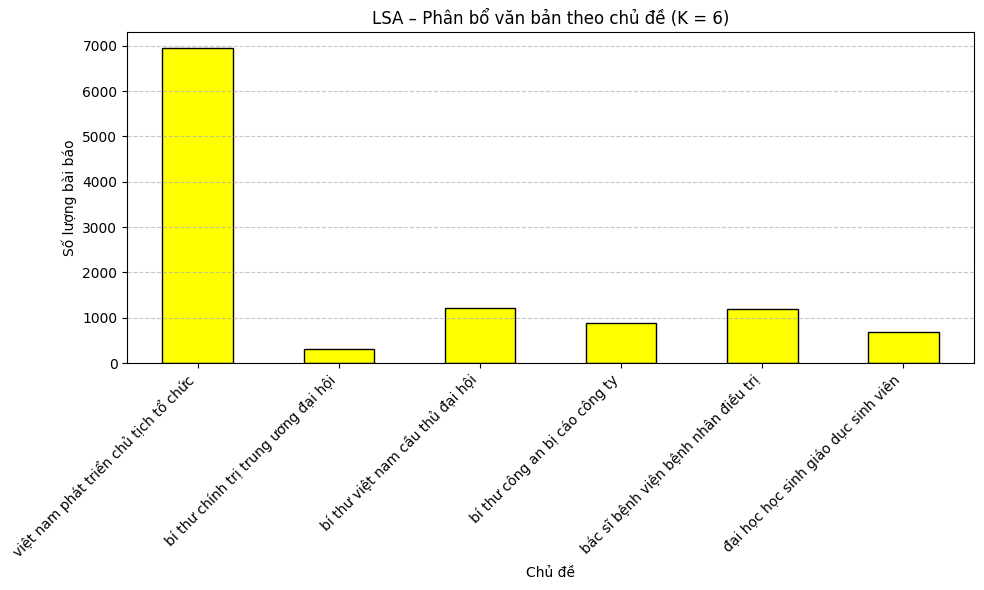

In [56]:
dominant_topic_lsa = X_lsa.argmax(axis=1)
topic_counts_lsa = (
    pd.Series(dominant_topic_lsa)
    .value_counts()
    .sort_index()
)
topic_counts_lsa

plt.figure(figsize=(10,6))

topic_counts_lsa.plot(
    kind="bar",
    edgecolor="black",
    color="yellow"
)

plt.title(f"LSA – Phân bổ văn bản theo chủ đề (K = {best_k_lsa})")
plt.xlabel("Chủ đề")
plt.ylabel("Số lượng bài báo")

plt.xticks(
    ticks=range(len(topic_counts_lsa)),
    labels=[topic_captions_lsa[i] for i in topic_counts_lsa.index],
    rotation=45,
    ha="right"
)

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()